# Sleep scoring

Load packages

In [47]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

Load downsampled recordings

In [48]:
folder_base = Path('Gaelle/Baseline_recording/GreenDotsOK/session1/OpenEphys/')

filename0 = folder_base / f'LFPwake0.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
filenamePKL = folder_base / f'EMGframeBoolean.pkl'

All = np.load(filename2, mmap_mode= 'r')
All0 = np.load(filename0, mmap_mode= 'r')
Bool = pd.read_pickle(filenamePKL)

Associate channels to brain areas

In [49]:
EMG = All[:, 22]#GL 11
PFC1 = All[:, 1]#GL 22
PFC2 = All[:, 15]#GL 23
PFC = PFC2 #- PFC1
S11 = All[:, 21]#GL 18
S12 = All[:, 23]#GL 19
S1 = S11 #- S11
CA11 = All0[:, 27]#GL 13
CA12 = All0[:, 29]#GL 15
CA13 = All[:, 1]
CA1 = CA12# - CA11

ThetaCh = CA1
Beta1Ch = PFC
Beta2Ch = S1


Visualise to determine what channel/stereochannel to use to extract muscular activity, delta, theta, beta and maybe index of higher frequency

In [50]:
start = 000000
end = len(EMG)
EMGs = EMG[start:end, np.newaxis]
PFC1s = PFC1[start:end, np.newaxis]
PFC2s = PFC2[start:end, np.newaxis]
PFCs = PFC[start:end, np.newaxis]
S11s = S11[start:end, np.newaxis]
S12s = S12[start:end, np.newaxis]
S1s = S1[start:end, np.newaxis]
CA11s = CA11[start:end, np.newaxis]
CA12s = CA12[start:end, np.newaxis]
CA1s = CA1[start:end, np.newaxis]
combined = np.append(EMGs, PFC1s, axis=1)
combined = np.append(combined, PFC2s, axis=1)
combined = np.append(combined, PFCs, axis=1)
combined = np.append(combined, S12s, axis=1)
combined = np.append(combined, S11s, axis=1)
combined = np.append(combined, S1s, axis=1)
combined = np.append(combined, CA11s, axis=1)
combined = np.append(combined, CA12s, axis=1)
combined = np.append(combined, CA1s, axis=1)

In [51]:
app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
view1.by_channel_params['ch4', 'color'] = '#ff5500'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch7', 'color'] = '#9b3b70'
view1.by_channel_params['ch8', 'color'] = '#9b3b70'
#view1.by_channel_params['ch9', 'color'] = '#9b3b70'



view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00006
view1.by_channel_params['ch4', 'gain'] = 0.00002
view1.by_channel_params['ch5', 'gain'] = 0.00002
view1.by_channel_params['ch6', 'gain'] = 0.00003
view1.by_channel_params['ch7', 'gain'] = 0.00002
view1.by_channel_params['ch8', 'gain'] = 0.00002
view1.by_channel_params['ch9', 'gain'] = 0.00002

view1.by_channel_params['ch0', 'offset'] = 0.5
view1.by_channel_params['ch1', 'offset'] = 0.4
view1.by_channel_params['ch2', 'offset'] = 0.3
view1.by_channel_params['ch3', 'offset'] = 0.2
view1.by_channel_params['ch4', 'offset'] = 0.1
view1.by_channel_params['ch5', 'offset'] = 0
view1.by_channel_params['ch6', 'offset'] = -0.1
view1.by_channel_params['ch7', 'offset'] = -0.2
view1.by_channel_params['ch8', 'offset'] = -0.3
view1.by_channel_params['ch9', 'offset'] = -0.4

#Run
win.show()
app.exec_()

0

## Build vigilance state scoring vector
[we use here liberal boolean for wake detection]

    ### 0 = wake
    ### 1 = REM
    ### >1 = NREM

    

Set all sleep at 1 and wake at 0

In [52]:
ScoringVectorLength = len(EMG)
ScoringVector = np.zeros((ScoringVectorLength))
WakeStatus = np.zeros((ScoringVectorLength))
EMGStatusBoolLib = Bool.BooleanLiberal
WakeStatus[EMGStatusBoolLib] = 1


Extract REM and set NREM at 2

In [53]:
# Filtre parameter:
f_lowcut = 5.
f_hicut = 9.
fs = 1000
nyq = 0.5 * fs
N = 4                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_Theta = signal.filtfilt(b, a, ThetaCh)

# Parameter and computation of CWT
w = 30.
freq = np.linspace(5, 9, 8)
widths = w*fs / (2*freq*np.pi)
ThetaCWT = signal.cwt(filt_Theta, signal.morlet2, widths, w=w)

# Projection calculation
absThetaCWT = np.absolute(ThetaCWT)
from scipy import stats

zabsThetaCWT = stats.zscore(absThetaCWT, axis=None)

proj_ThetaCWT = np.max(zabsThetaCWT, axis = 0)/8
sdproj_ThetaCWT = np.std(proj_ThetaCWT)
meanproj_ThetaCWT = np.mean(proj_ThetaCWT)

numpnts = EMG.size
ThetaStatus = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_ThetaCWT[ind]>(meanproj_ThetaCWT+1.4*sdproj_ThetaCWT):
        ThetaStatus[ind] = 1



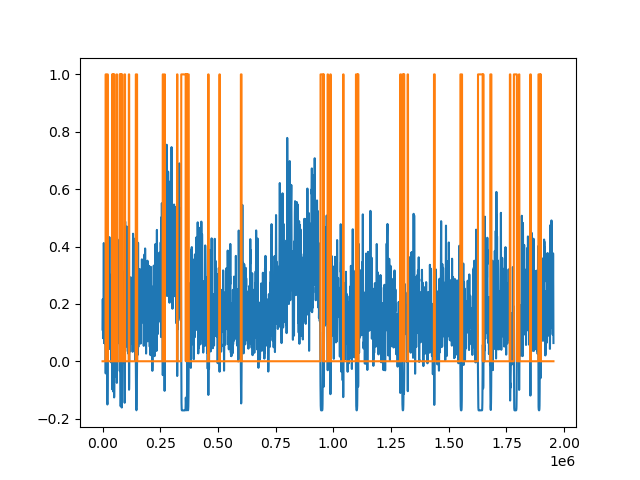

In [54]:
plt.close()
plt.plot(proj_ThetaCWT)
plt.plot(WakeStatus)

plt.show()

Extract beta 

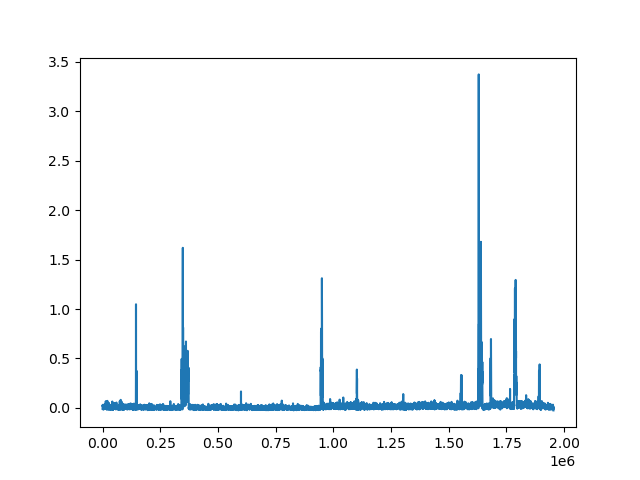

In [55]:

# Filtre parameter:
f_lowcut = 10.
f_hicut = 18.
fs = 1000
nyq = 0.5 * fs
N = 4                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_Beta1 = signal.filtfilt(b, a, Beta1Ch)
filt_Beta2 = signal.filtfilt(b, a, Beta2Ch)

# Parameter and computation of CWT
w = 10.
freq = np.linspace(10, 18, 16)
widths = w*fs / (2*freq*np.pi)
Beta1CWT = signal.cwt(filt_Beta1, signal.morlet2, widths, w=w)
Beta2CWT = signal.cwt(filt_Beta2, signal.morlet2, widths, w=w)

# Projection calculation
absBeta1CWT = np.absolute(Beta1CWT)
absBeta2CWT = np.absolute(Beta2CWT)
from scipy import stats

zabsBeta1CWT = stats.zscore(absBeta1CWT, axis=None)
zabsBeta2CWT = stats.zscore(absBeta2CWT, axis=None)

proj_Beta1CWT = np.max(zabsBeta1CWT, axis = 0)/16
proj_Beta2CWT = np.max(zabsBeta2CWT, axis = 0)/16
meanproj_Beta1CWT = np.mean(zabsBeta1CWT)
meanproj_Beta2CWT = np.mean(zabsBeta2CWT)
sdproj_Beta1CWT = np.std(proj_Beta1CWT)
sdproj_Beta2CWT = np.std(proj_Beta2CWT)

numpnts = EMG.size
Beta1Status = np.zeros(numpnts)
Beta2Status = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_Beta1CWT[ind]>(meanproj_Beta1CWT+3*sdproj_Beta1CWT):
        Beta1Status[ind] = 1
    if proj_Beta2CWT[ind]>(meanproj_Beta2CWT+3*sdproj_Beta2CWT):
        Beta2Status[ind] = 1


plt.close()
plt.plot(proj_Beta2CWT)
plt.show()

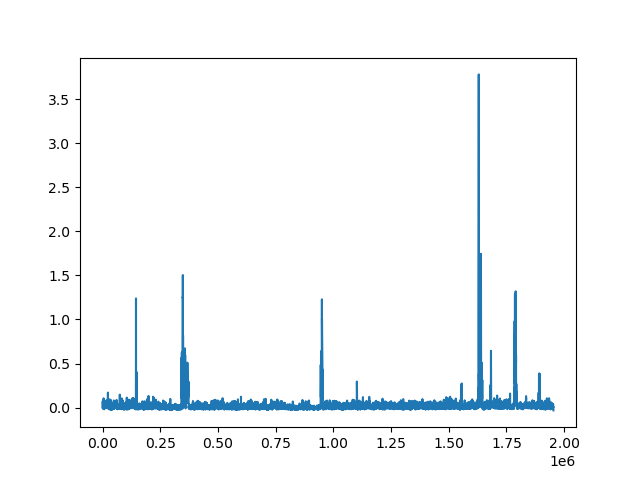

In [56]:
plt.close()
plt.plot(proj_Beta1CWT)
#plt.plot(proj_Beta2CWT)
#plt.plot(WakeStatus)

plt.show()

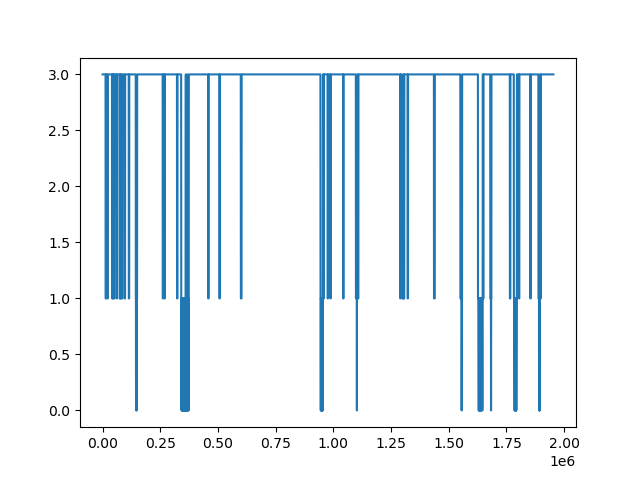

In [57]:
ScoringVector = np.ones((ScoringVectorLength))
for ind in range(numpnts):
    if ThetaStatus[ind]>0:
        ScoringVector[ind] = 2
    if Beta1Status[ind]>0:
        ScoringVector[ind] = 0
    if WakeStatus[ind]==0:
        ScoringVector[ind] = 3

plt.close()
plt.plot(ScoringVector)
plt.show()

Reduce bins

In [58]:
input_arr = ThetaStatus

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)

dwnsmpl_subarr = np.split(input_arr, split_arr[1:])

dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )

for i in range(len(dwnsmpl_arrT)):
    if dwnsmpl_arrT[i]<0.25:
        dwnsmpl_arrT[i] = 0
    else:
        dwnsmpl_arrT[i] = 1  

for i in range(len(dwnsmpl_arrT)-3):
    if i > (len(dwnsmpl_arrT)-3):
        print(i)
        break          
    elif (dwnsmpl_arrT[i]>0 and dwnsmpl_arrT[i+2]>0):
        dwnsmpl_arrT[i+1]=1
    elif (dwnsmpl_arrT[i]>0 and dwnsmpl_arrT[i+3]>0):
        dwnsmpl_arrT[i+1]=1
        dwnsmpl_arrT[i+2]=1

for i in range(len(dwnsmpl_arrT)):
    if i > (len(dwnsmpl_arrT)-3):
        print(i)
        break
    elif (dwnsmpl_arrT[i]<1 and dwnsmpl_arrT[i+1]>0 and dwnsmpl_arrT[i+2]<1):
        dwnsmpl_arrT[i+1]=0


389


In [59]:
input_arr1 = proj_Beta1CWT
input_arr2 = proj_Beta2CWT

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr1 = np.linspace(0, len(input_arr1), num=R+1, dtype=int)
split_arr2 = np.linspace(0, len(input_arr2), num=R+1, dtype=int)

dwnsmpl_subarr1 = np.split(input_arr1, split_arr1[1:])
dwnsmpl_subarr2 = np.split(input_arr2, split_arr2[1:])

dwnsmpl_arr1B = np.array( list( np.mean(item) for item in dwnsmpl_subarr1[:-1] ) )
dwnsmpl_arr2B = np.array( list( np.mean(item) for item in dwnsmpl_subarr2[:-1] ) )

for i in range(len(dwnsmpl_arr1B)):
    if dwnsmpl_arr1B[i]<0.12: # arbitrary set
        dwnsmpl_arr1B[i] = 0
    else:
        dwnsmpl_arr1B[i] = 1  

for i in range(len(dwnsmpl_arr1B)-3):
    if i > (len(dwnsmpl_arr1B)-3):
        break                 
    elif (dwnsmpl_arr1B[i]>0 and dwnsmpl_arr1B[i+2]>0):
        dwnsmpl_arr1B[i+1]=1
    elif (dwnsmpl_arr1B[i]>0 and dwnsmpl_arr1B[i+3]>0):
        dwnsmpl_arr1B[i+1]=1
        dwnsmpl_arr1B[i+2]=1

for i in range(len(dwnsmpl_arr2B)):
    if dwnsmpl_arr2B[i]<0.12: # arbitrary set
        dwnsmpl_arr2B[i] = 0
    else:
        dwnsmpl_arr2B[i] = 1  

for i in range(len(dwnsmpl_arr2B)-3):          
    if (dwnsmpl_arr2B[i]>0 and dwnsmpl_arr2B[i+2]>0):
        dwnsmpl_arr2B[i+1]=1
    elif (dwnsmpl_arr2B[i]>0 and dwnsmpl_arr2B[i+3]>0):
        dwnsmpl_arr2B[i+1]=1
        dwnsmpl_arr2B[i+2]=1



In [60]:
input_arrW = WakeStatus

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)

dwnsmpl_subarr = np.split(input_arrW, split_arr[1:])

dwnsmpl_arrW = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )

for i in range(len(dwnsmpl_arrW)):
    if dwnsmpl_arrW[i]<0.2: # arbitrary set
        dwnsmpl_arrW[i] = 0
    else:
        dwnsmpl_arrW[i] = 1 


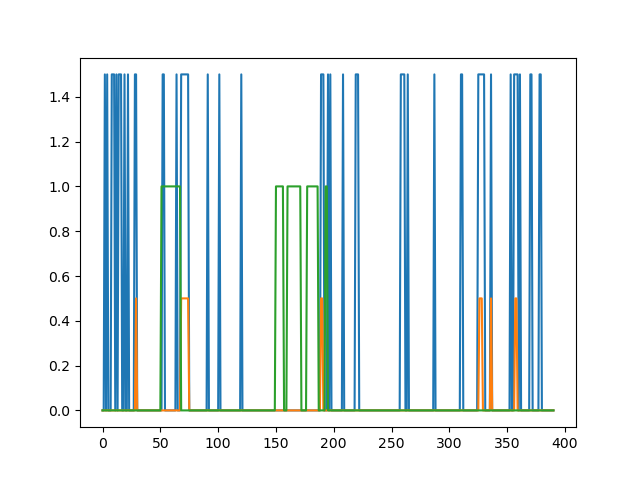

In [61]:
dwnsmpl_arrT = dwnsmpl_arrT * 1
dwnsmpl_arrW = dwnsmpl_arrW * 1.5
dwnsmpl_arr1B = dwnsmpl_arr1B * 0.5

plt.close()
plt.plot(dwnsmpl_arrW)
plt.plot(dwnsmpl_arr1B)
plt.plot(dwnsmpl_arrT)
plt.show()

388


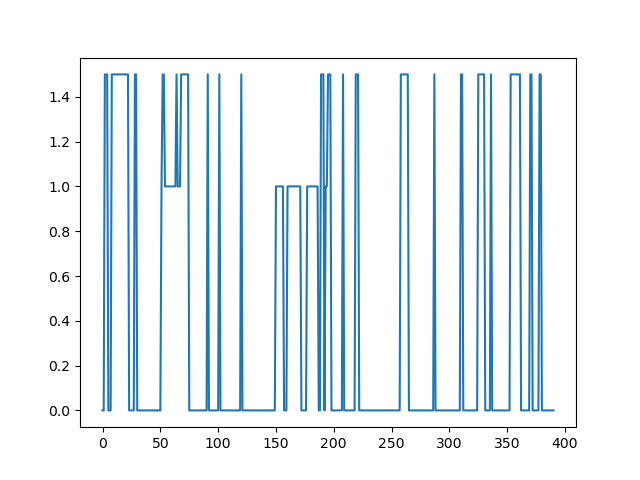

In [62]:
ScoringVectorS = np.zeros((len(dwnsmpl_arrW)))
for ind in range(len(dwnsmpl_arrW)):
    if dwnsmpl_arr1B[ind]>0:
        ScoringVectorS[ind] = 0.5
    if dwnsmpl_arrT[ind]>0:
        ScoringVectorS[ind] = 1
    if dwnsmpl_arrW[ind]>0:
        ScoringVectorS[ind] = 1.5



for i in range(len(ScoringVectorS)):
    if i > (len(ScoringVectorS)-4):
        print(i)
        break          
    elif (ScoringVectorS[i]==0.5 and ScoringVectorS[i+1]==0 and ScoringVectorS[i+2]>0):
        ScoringVectorS[i+1]=0.5
    elif (ScoringVectorS[i]==1 and ScoringVectorS[i+1]==0 and ScoringVectorS[i+2]>0):
        ScoringVectorS[i+1]=1
    elif (ScoringVectorS[i]==1.5 and ScoringVectorS[i+1]<1.5 and (ScoringVectorS[i+2]==1.5 or ScoringVectorS[i+3]==1.5)):
        ScoringVectorS[i+1]=1.5



plt.close()
plt.plot(ScoringVectorS)
plt.show()

In [63]:
filenameOut = folder_base / f'ScoredSleep.npy'
np.save(filenameOut, ScoringVectorS)

